<img src="https://github.com/PKhosravi-CityTech/LightCnnRad/raw/main/Images/BioMindLogo.png" alt="BioMind AI Lab Logo" width="150" height="150" align="left" style="margin-bottom: 40px;"> **Repository Developed by Pegah Khosravi, Principal Investigator of the BioMind AI Lab**

Welcome to this repository! This repository is a result of collaborative efforts from our dedicated team at the lab. We are committed to advancing the field of biomedical AI and pushing the boundaries of medical data analysis. Your interest and contributions to our work are greatly appreciated. For more information about our lab and ongoing projects, please visit the [BioMind AI Lab website](https://sites.google.com/view/biomind-ai-lab). Thank you for your interest and support!



ExCapNet Model for Extracapsular Extension Detection in MRI Images
----------------------------------------------------------------

The ExCapNet model is a deep learning architecture designed for the detection of extracapsular extension in MRI images. This task involves classifying images into one of two categories, indicating the presence or absence of extracapsular extension. The model utilizes a convolutional neural network (CNN) to automatically learn relevant features from the input images. It consists of several convolutional layers followed by batch normalization, ReLU activation, and max-pooling. The learned features are then fed through fully connected layers to make the final prediction.

The architecture of the ExCapNet model is designed to capture intricate patterns and features from the MRI images that are indicative of extracapsular extension. By training on labeled data, the model learns to distinguish between the different classes, enabling it to provide accurate predictions on new, unseen MRI images.

This script contains the implementation of the ExCapNet model using PyTorch. After defining the architecture, the model is instantiated and ready to be trained and evaluated. Adjust the 'num_classes' parameter as needed for your specific classification task.




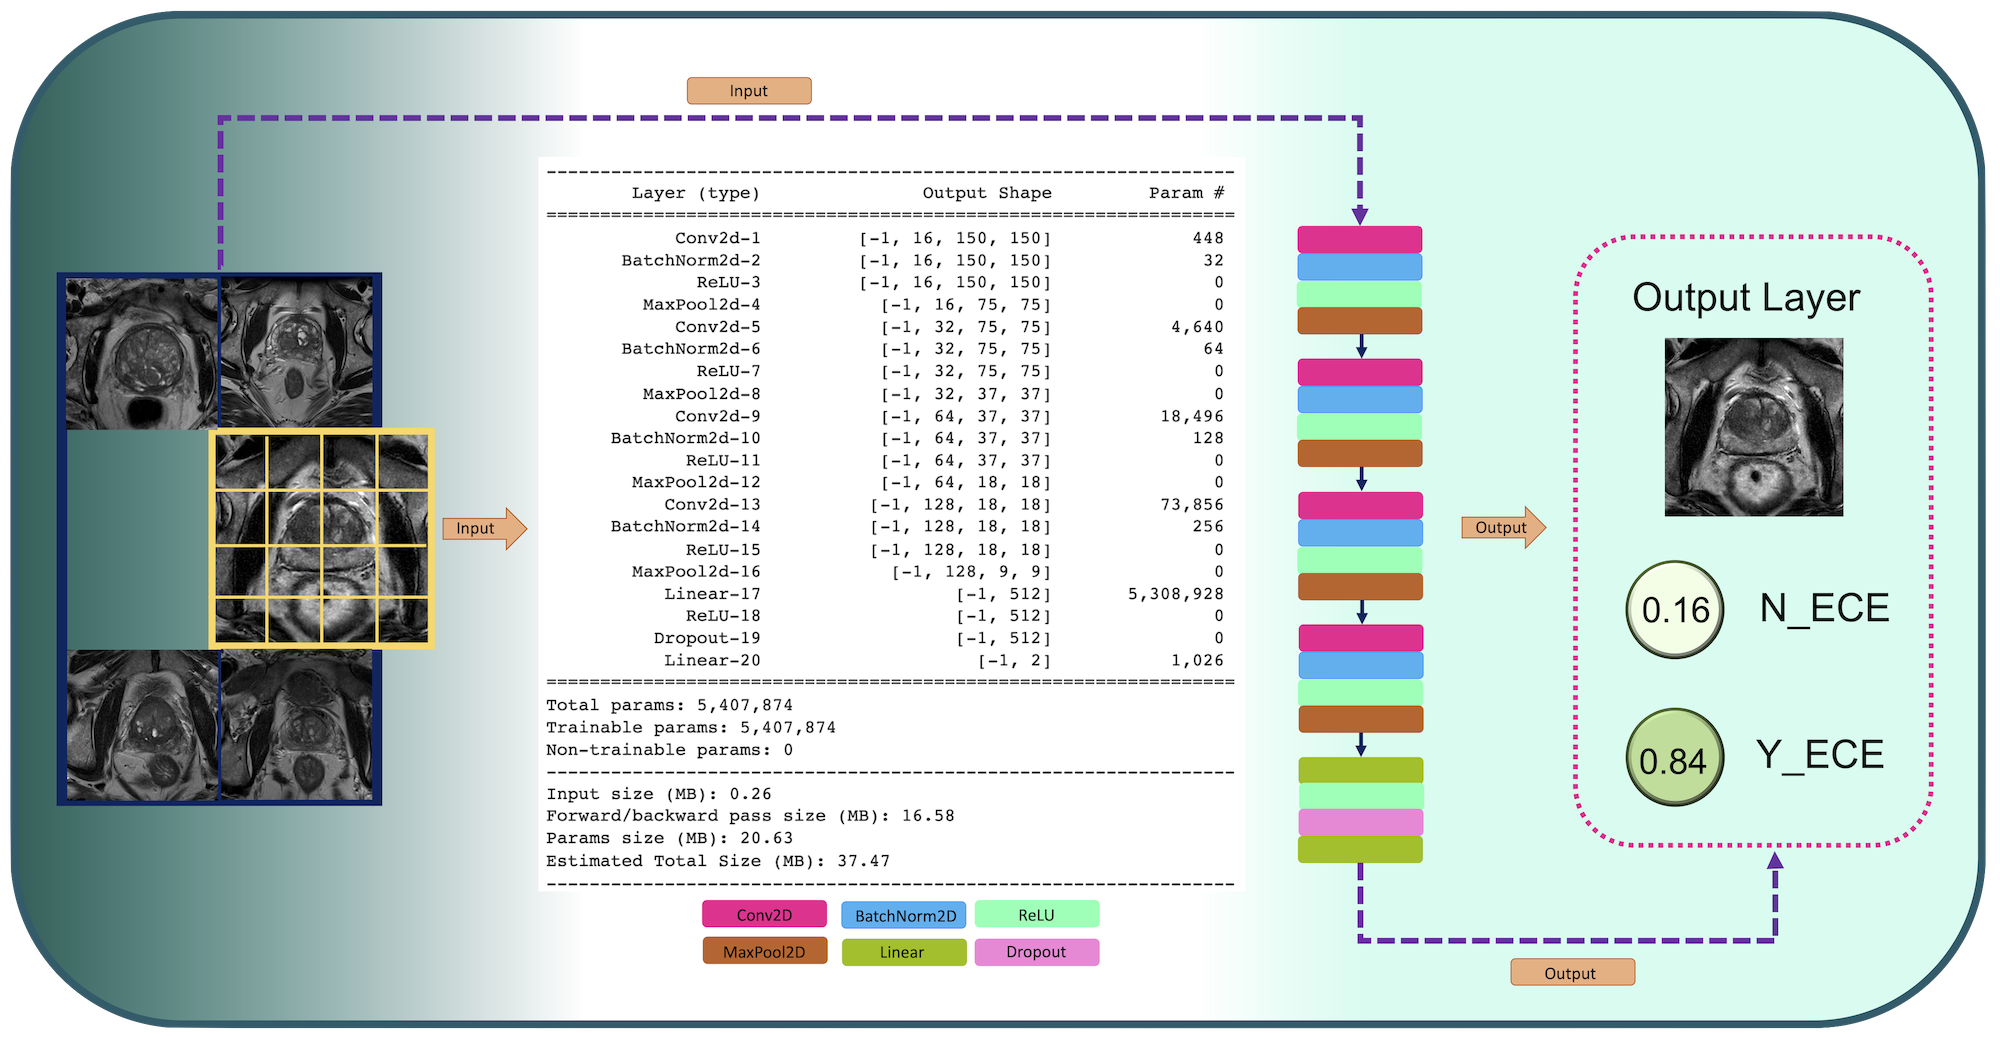

The ExCapNet GitHub repository provides a comprehensive resource suitable for both experts and beginners in the realm of deep learning and clinical image analysis. Particularly noteworthy is the inclusion of a meticulously curated Colab file, accompanied by step-by-step instructions. This feature is designed to empower newcomers, enabling them to confidently navigate the model training process. With its user-friendly approach, the Colab file serves as a valuable guide, allowing novices to embark on a successful journey of model training without unnecessary complexities. Whether you are a seasoned practitioner or a novice eager to explore the world of deep learning, the ExCapNet GitHub repository equips you with the necessary tools and guidance to effectively harness the potential of this innovative algorithm.

#GPU
Ensure that your GPU is active before proceeding with the image upload and code execution. You can configure the GPU settings under "Runtime."

# Upload images

We are working with MR images provided at Global Robotics Institute.

Let's upload the images to Google Drive to ensure they are not lost every time we run the code in Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's extract the contents of the compressed zip file.

In [ ]:
import zipfile
!unzip "/content/gdrive/MyDrive/ColabNotebooks_PegahKhosravi/Prostate_Project/Data_Final.zip" -d Test

Please remove the "__MACOSX" file; it is unnecessary for our purposes.

In [ ]:
!rm -rf '/content/data/__MACOSX'

Import all the necessary libraries.

In [ ]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [ ]:
#Dataloader

#Path for Training, Validation, and Test directory
train_path="/content/data/Data_Final/Training"
validation_path="/content/data/Data_Final/Validation"
pred_path="/content/data/Data_Final/Test"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)
validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [ ]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

Remove the ".DS_Store" file from the training, validation, and test sets, as it is not needed. Please execute this section twice for each set, and before each run, ensure to execute the code above to ensure a clear path from the root.

In [ ]:
!rm "/content/data/Data_Final/Validation/.DS_Store"

In [ ]:
print(classes)

['N', 'Y']


In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [ ]:
#new architecture

import torch.nn as nn

class ExCapNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ExCapNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        self.relu4 = nn.ReLU()

        self.fc1 = nn.Linear(in_features=128 * 18 * 18 // 4, out_features=512)
        self.relu5 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool(output)

        output = self.conv4(output)
        output = self.bn4(output)
        output = self.relu4(output)
        output = self.pool(output)

        output = output.view(-1, 128 * 18 * 18 // 4)


        output = self.fc1(output)
        output = self.relu5(output)
        output = self.dropout(output)

        output = self.fc2(output)

        return output

# Instantiate the model
model = ExCapNet(num_classes=2).to(device)


Now, let's define the optimizers.

In [ ]:
#https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/
from torch.optim.adamw import AdamW
from torch.optim.adamax import Adamax
from torch.optim.sparse_adam import SparseAdam
from torch.optim.sgd import SGD
from torch.optim.adagrad import Adagrad
from torch.optim.rmsprop import RMSprop
#Optmizer and loss function
#optimizer=AdamW(model.parameters(),lr=0.00001,weight_decay=0.01)
#optimizer=SGD(model.parameters(),lr=0.001,momentum=0.7)
#optimizer=RMSprop(model.parameters(), lr=0.00001, alpha=0.99, eps=1e-08, weight_decay=0.00001, momentum=0, centered=False)
#loss_function=nn.NLLLoss()
#loss_function=nn.KLDivLoss()
loss_function=nn.CrossEntropyLoss()

In [ ]:
optimizer = RMSprop(
    model.parameters(),
    lr=0.0001,      # Slightly higher starting learning rate
    alpha=0.8,       # Adjusted alpha
    eps=1e-08,
    weight_decay=0.00001,
    momentum=0.8,    # Added momentum
    centered=False
)


Next, let's set the desired number of epochs for training the model.

In [ ]:
num_epochs=30

In [ ]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
validation_count=len(glob.glob(validation_path+'/**/*.png'))

Now, let's take a look at the number of images present in both the training and validation folders.

In [ ]:
print(train_count,validation_count)

4802 608


In [ ]:
from torch.optim.lr_scheduler import StepLR
# Instantiate a learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust step_size and gamma as needed

import matplotlib.pyplot as plt

# Initialize lists to store accuracy and loss values
train_accuracies = []
validation_accuracies = []
train_losses = []
validation_losses = []

# Model training and saving best model
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * 128  # Use actual batch size
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / len(train_loader.dataset)  # Total number of training samples
    train_loss = train_loss / len(train_loader.dataset)

    # Evaluation on validation dataset
    model.eval()
    validation_accuracy = 0.0
    validation_loss = 0.0
    for i, (images, labels) in enumerate(validation_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        loss = loss_function(outputs, labels)
        validation_loss += loss.cpu().data * 64  # Use actual batch size
        _, prediction = torch.max(outputs.data, 1)
        validation_accuracy += int(torch.sum(prediction == labels.data))

    validation_accuracy = validation_accuracy / len(validation_loader.dataset)  # Total number of validation samples
    validation_loss = validation_loss / len(validation_loader.dataset)

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Validation Loss: ' + str(validation_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' Validation Accuracy: ' + str(validation_accuracy))

    # Step the learning rate scheduler
    scheduler.step()

    # Append accuracy and loss values to the lists
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    # Save the best model
    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = validation_accuracy


Epoch: 0 Train Loss: tensor(1.2219) Validation Loss: tensor(0.7214) Train Accuracy: 0.5279050395668472 Validation Accuracy: 0.5460526315789473
Epoch: 1 Train Loss: tensor(0.5713) Validation Loss: tensor(0.5272) Train Accuracy: 0.7042898792169929 Validation Accuracy: 0.7154605263157895
Epoch: 2 Train Loss: tensor(0.4610) Validation Loss: tensor(0.5060) Train Accuracy: 0.7869637650978759 Validation Accuracy: 0.7549342105263158
Epoch: 3 Train Loss: tensor(0.4664) Validation Loss: tensor(0.4908) Train Accuracy: 0.7900874635568513 Validation Accuracy: 0.7335526315789473
Epoch: 4 Train Loss: tensor(0.3728) Validation Loss: tensor(0.7980) Train Accuracy: 0.8344439816743023 Validation Accuracy: 0.6726973684210527
Epoch: 5 Train Loss: tensor(0.2534) Validation Loss: tensor(0.5086) Train Accuracy: 0.8950437317784257 Validation Accuracy: 0.71875
Epoch: 6 Train Loss: tensor(0.2229) Validation Loss: tensor(0.5244) Train Accuracy: 0.9158683881715952 Validation Accuracy: 0.7203947368421053
Epoch: 7 T

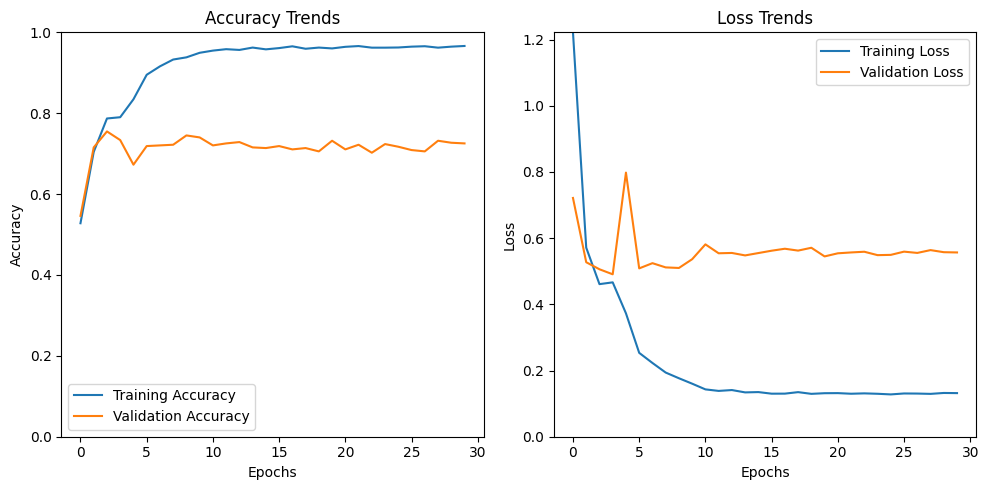

In [ ]:
# Plotting the accuracy trends
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trends')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1

# Plotting the loss trends
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trends')
plt.legend()
plt.ylim(0, max(max(train_losses), max(validation_losses)))  # Set y-axis limits from 0 to max value in data

# Display the plots
plt.tight_layout()
plt.show()

Now, let's test the best model on a blind test set. You can proceed with the following code for prediction.

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

In [ ]:
train_path="/content/data/Data_Final/Training"
pred_path="/content/data/Data_Final/Test"

In [ ]:
test_count=len(glob.glob(pred_path+'/*.png'))

In [ ]:
print(test_count)

405


In [ ]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
checkpoint=torch.load("best_checkpoint.model")
model=ExCapNet(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

This illustrates the architecture of your model and the number of parameters that need to be calculated during the training process.

In [ ]:
from torchsummary import summary

model=model.cuda()

summary(model, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
       BatchNorm2d-2         [-1, 16, 150, 150]              32
              ReLU-3         [-1, 16, 150, 150]               0
         MaxPool2d-4           [-1, 16, 75, 75]               0
            Conv2d-5           [-1, 32, 75, 75]           4,640
       BatchNorm2d-6           [-1, 32, 75, 75]              64
              ReLU-7           [-1, 32, 75, 75]               0
         MaxPool2d-8           [-1, 32, 37, 37]               0
            Conv2d-9           [-1, 64, 37, 37]          18,496
      BatchNorm2d-10           [-1, 64, 37, 37]             128
             ReLU-11           [-1, 64, 37, 37]               0
        MaxPool2d-12           [-1, 64, 18, 18]               0
           Conv2d-13          [-1, 128, 18, 18]          73,856
      BatchNorm2d-14          [-1, 128,

In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [ ]:
# Prediction function
def prediction(img_path, transformer, model):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    with torch.no_grad():  # No need to compute gradients during inference
        input = Variable(image_tensor)
        output = model(input)

    prob = nn.functional.softmax(output, dim=1)
    prob = prob.cpu().detach().numpy()  # Move the tensor to CPU and then convert to numpy
    return prob

# Load the model and move it to the same device as the data
model = ExCapNet(num_classes=2)
model.load_state_dict(checkpoint)
if torch.cuda.is_available():
    model.cuda()

images_path = glob.glob(pred_path + '/*.png')
pred_dict = {}

for i in images_path:
    filename = i[i.rfind('/') + 1:]
    prob_array = prediction(i, transformer, model)
    pred_dict[filename] = prob_array

# Print the probabilities in the desired format
for filename, prob_array in pred_dict.items():
    print(f"'{filename}': np.array({np.array2string(prob_array, separator=', ', formatter={'float_kind': lambda x: f'{x:.8e}'} )}, dtype=np.float32),")

In [ ]:
import csv
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

# Define the path for saving the CSV file
output_csv_path = '/content/predictions.csv'

# Save prediction results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Predicted Class', 'Probability'])

    for filename, prob_array in pred_dict.items():
        predicted_class = 'Y' if prob_array[0][1] > 0.5 else 'N'  # Adjust the threshold as needed
        probability = prob_array[0][1]
        csvwriter.writerow([filename, predicted_class, probability])

print("Prediction results saved to", output_csv_path)


Prediction results saved to /content/predictions.csv


Now, let's save the results in a file named "predictions.csv".

In [ ]:
import csv
import numpy as np

# Set the desired threshold for considering predictions as positive
positive_threshold = 0.5

# Define the path for saving the CSV file
output_csv_path = '/content/predictions_vote.csv'

# Dictionary to store patient-wise predictions
patient_predictions = {}

# Populate the dictionary with individual image predictions
for filename, prob_array in pred_dict.items():
    patient_id = "_".join(filename.split('_')[:-1])  # Extract patient ID without the last part of the filename
    prediction = prob_array[0][1]

    if patient_id not in patient_predictions:
        patient_predictions[patient_id] = []

    patient_predictions[patient_id].append(prediction)

# Calculate majority vote and save results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Predict'])

    for patient_id, predictions in patient_predictions.items():
        majority_vote = sum(predictions) / len(predictions)
        if majority_vote >= positive_threshold or (1 - majority_vote) >= positive_threshold:
            csvwriter.writerow([patient_id, majority_vote])  # Writing patient ID and majority vote prediction

print("Prediction results saved to", output_csv_path)


Prediction results saved to /content/predictions_vote.csv


Finally, let's draw the ROC curve and Confusion Matrix, along with other measurements.

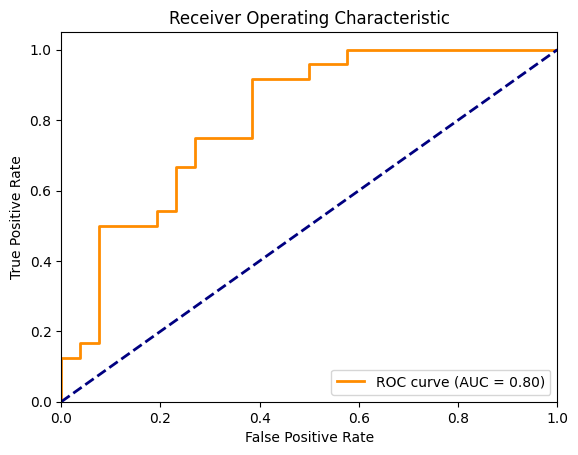

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load data from predictions.csv
df = pd.read_csv('predictions_vote.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']
predicted_probs = df['Predict']

# Convert labels to binary format (0 for 'N_' and 1 for 'Y_')
true_labels = true_labels.apply(lambda x: 0 if x.startswith('N_') else 1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

True Positive: 18
True Negative: 17
False Positive: 9
False Negative: 6
Accuracy: 0.7
Sensitivity (True Positive Rate): 0.75
Specificity (True Negative Rate): 0.6538461538461539


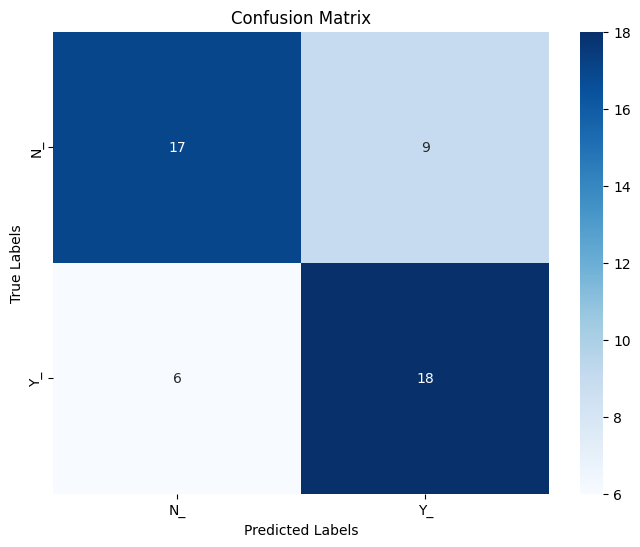

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file containing predictions
df = pd.read_csv('predictions_vote.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']

# Preprocess true labels to extract class labels (e.g., 'N_' or 'T_')
class_labels = ['N_', 'Y_']
true_labels_processed = [label[:2] for label in true_labels]

# Threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = np.where(df['Predict'] >= threshold, 'Y_', 'N_')

# Calculate confusion matrix
cm = confusion_matrix(true_labels_processed, binary_predictions, labels=class_labels)

# Extract TP, TN, FP, FN from confusion matrix
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

# Calculate accuracy, sensitivity (True Positive Rate), and specificity (True Negative Rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Display TP, TN, FP, FN
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Display accuracy, sensitivity, and specificity
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

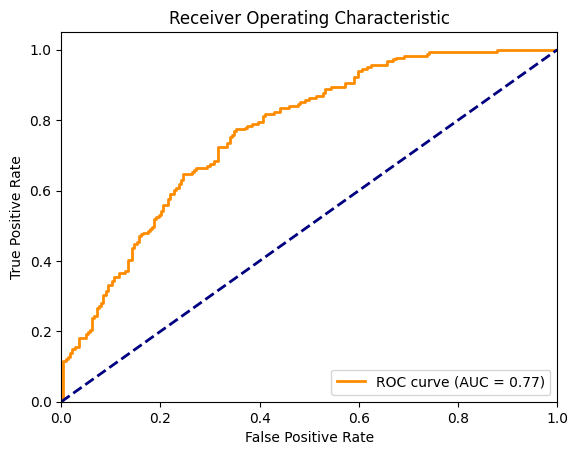

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load data from predictions.csv
df = pd.read_csv('predictions.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']
predicted_probs = df['Probability']

# Convert labels to binary format (0 for 'N_' and 1 for 'Y_')
true_labels = true_labels.apply(lambda x: 0 if x.startswith('N_') else 1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

True Positive: 135
True Negative: 148
False Positive: 76
False Negative: 46
Accuracy: 0.6987654320987654
Sensitivity (True Positive Rate): 0.7458563535911602
Specificity (True Negative Rate): 0.6607142857142857


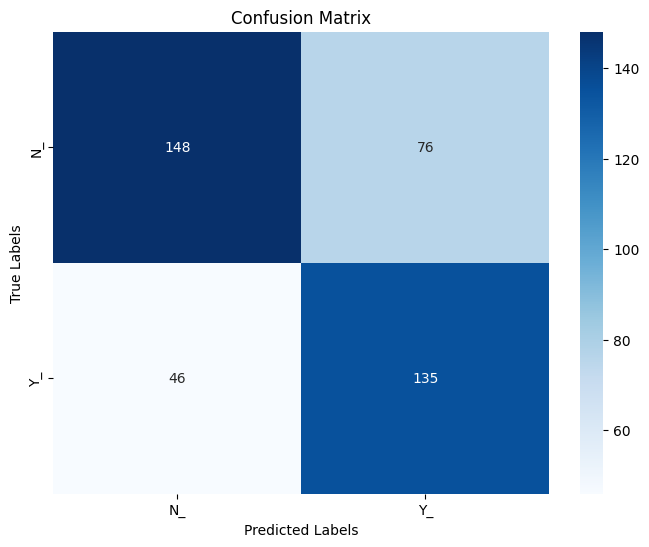

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file containing predictions
df = pd.read_csv('predictions.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']

# Preprocess true labels to extract class labels (e.g., 'N_' or 'T_')
class_labels = ['N_', 'Y_']
true_labels_processed = [label[:2] for label in true_labels]

# Threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = np.where(df['Probability'] >= threshold, 'Y_', 'N_')

# Calculate confusion matrix
cm = confusion_matrix(true_labels_processed, binary_predictions, labels=class_labels)

# Extract TP, TN, FP, FN from confusion matrix
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

# Calculate accuracy, sensitivity (True Positive Rate), and specificity (True Negative Rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Display TP, TN, FP, FN
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Display accuracy, sensitivity, and specificity
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import zipfile
!unzip "/content/gdrive/MyDrive/ColabNotebooks_PegahKhosravi/Prostate_Project/Test_Outside_Final.zip" -d Outside

In [ ]:
train_path="/content/data/Data_Final/Training"
pred_path="/content/Outside/Test_Outside_Final"

In [ ]:
!rm -rf '/content/Outside/.ipynb_checkpoints'

In [ ]:
!rm -rf '/content/Outside/Test_Outside_Final/.DS_Store'

In [ ]:
test_count=len(glob.glob(pred_path+'/*.png'))

In [ ]:
print(test_count)

340


In [ ]:
# Transformations to preprocess input images before feeding to the model
transformer = transforms.Compose([
    # Resize the image to (150, 150) pixels
    transforms.Resize((150, 150)),

    # Convert the image to a tensor (0-255 to 0-1), and reshape it to (C, H, W)
    # where C represents the number of channels (3 for RGB), and H, W are height and width
    transforms.ToTensor(),

    # Normalize the tensor values to a range of [-1, 1]
    # by applying (x - mean) / std where mean = 0.5 and std = 0.5
    transforms.Normalize(
        [0.5, 0.5, 0.5],   # Mean for each channel (RGB)
        [0.5, 0.5, 0.5]    # Standard deviation for each channel (RGB)
    )
])

In [ ]:
# Prediction function to predict class probabilities for an input image
def prediction(img_path, transformer, model):
    # Open and load the input image
    image = Image.open(img_path)

    # Apply transformations to the image
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    # Perform inference (no need to compute gradients)
    with torch.no_grad():
        input = Variable(image_tensor)
        output = model(input)

    # Calculate class probabilities using softmax
    prob = nn.functional.softmax(output, dim=1)

    # Convert the tensor to a numpy array and move it to CPU
    prob = prob.cpu().detach().numpy()

    return prob

# Load the trained model and move it to the appropriate device (CPU or GPU)
model = ExCapNet(num_classes=2)  # Create an instance of the LightCnnRad
model.load_state_dict(checkpoint)  # Load the trained model's weights
if torch.cuda.is_available():
    model.cuda()  # Move the model to GPU if available

# Get a list of image paths to predict
images_path = glob.glob(pred_path + '/*.png')

# Dictionary to store predictions
pred_dict = {}

# Loop through each image and make predictions
for i in images_path:
    filename = i[i.rfind('/') + 1:]  # Extract the filename from the path
    prob_array = prediction(i, transformer, model)  # Get predicted probabilities
    pred_dict[filename] = prob_array  # Store the probabilities in the dictionary

# Print the probabilities in the desired format
for filename, prob_array in pred_dict.items():
    formatted_prob_array = np.array2string(
        prob_array, separator=', ', formatter={'float_kind': lambda x: f'{x:.8e}'}
    )
    print(f"'{filename}': np.array({formatted_prob_array}, dtype=np.float32),")

In [ ]:
import csv
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

# Define the path for saving the CSV file
output_csv_path = '/content/predictions_outside.csv'

# Save prediction results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Predicted Class', 'Probability'])

    for filename, prob_array in pred_dict.items():
        predicted_class = 'Y' if prob_array[0][1] > 0.5 else 'N'  # Adjust the threshold as needed
        probability = prob_array[0][1]
        csvwriter.writerow([filename, predicted_class, probability])

print("Prediction results saved to", output_csv_path)


Prediction results saved to /content/predictions_outside.csv


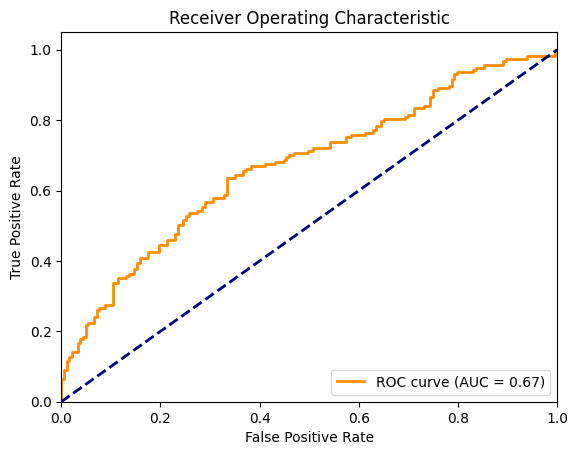

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load data from predictions.csv
df = pd.read_csv('predictions_outside.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']
predicted_probs = df['Probability']

# Convert labels to binary format (1 for 'Dis_' and 0 for 'Non_')
true_labels = true_labels.apply(lambda x: 0 if x.startswith('N_') else 1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

True Positive: 101
True Negative: 116
False Positive: 67
False Negative: 56
Accuracy: 0.638235294117647
Sensitivity (True Positive Rate): 0.643312101910828
Specificity (True Negative Rate): 0.6338797814207651


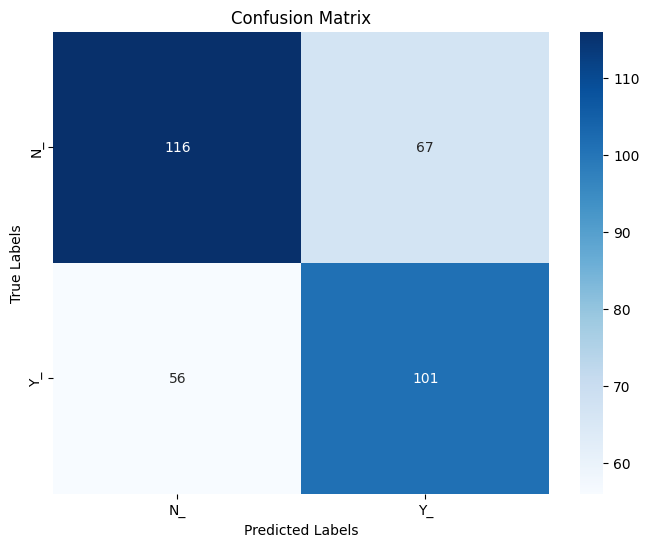

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file containing predictions
df = pd.read_csv('predictions_outside.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']

# Preprocess true labels to extract class labels (e.g., 'N_' or 'T_')
class_labels = ['N_', 'Y_']
true_labels_processed = [label[:2] for label in true_labels]

# Threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = np.where(df['Probability'] >= threshold, 'Y_', 'N_')

# Calculate confusion matrix
cm = confusion_matrix(true_labels_processed, binary_predictions, labels=class_labels)

# Extract TP, TN, FP, FN from confusion matrix
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

# Calculate accuracy, sensitivity (True Positive Rate), and specificity (True Negative Rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Display TP, TN, FP, FN
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Display accuracy, sensitivity, and specificity
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import csv
import numpy as np

# Set the desired threshold for considering predictions as positive
positive_threshold = 0.5

# Define the path for saving the CSV file
output_csv_path = '/content/predictions_vote_outside.csv'

# Dictionary to store patient-wise predictions
patient_predictions = {}

# Populate the dictionary with individual image predictions
for filename, prob_array in pred_dict.items():
    patient_id = "_".join(filename.split('_')[:-1])  # Extract patient ID without the last part of the filename
    prediction = prob_array[0][1]

    if patient_id not in patient_predictions:
        patient_predictions[patient_id] = []

    patient_predictions[patient_id].append(prediction)

# Calculate majority vote and save results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Predict'])

    for patient_id, predictions in patient_predictions.items():
        majority_vote = sum(predictions) / len(predictions)
        if majority_vote >= positive_threshold or (1 - majority_vote) >= positive_threshold:
            csvwriter.writerow([patient_id, majority_vote])  # Writing patient ID and majority vote prediction

print("Prediction results saved to", output_csv_path)

Prediction results saved to /content/predictions_vote_outside.csv


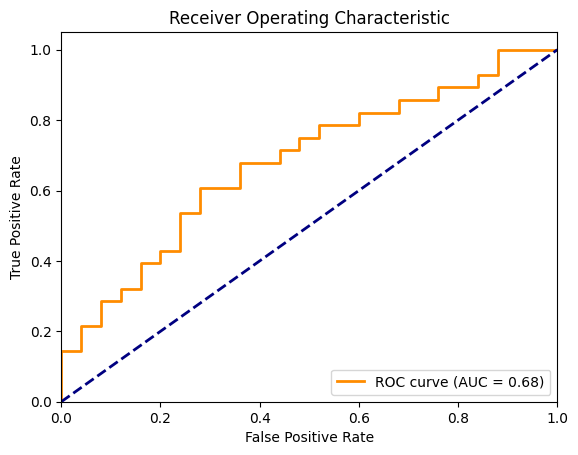

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load data from predictions.csv
df = pd.read_csv('predictions_vote_outside.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']
predicted_probs = df['Predict']

# Convert labels to binary format (1 for 'Dis_' and 0 for 'Non_')
true_labels = true_labels.apply(lambda x: 0 if x.startswith('N_') else 1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

True Positive: 19
True Negative: 14
False Positive: 11
False Negative: 9
Accuracy: 0.6226415094339622
Sensitivity (True Positive Rate): 0.6785714285714286
Specificity (True Negative Rate): 0.56


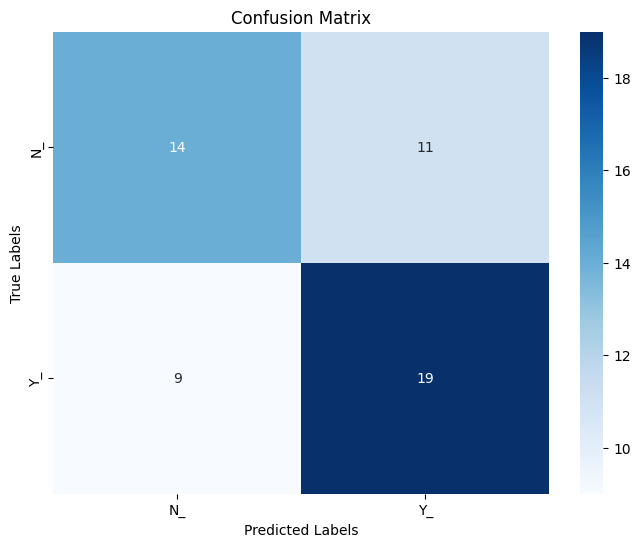

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file containing predictions
df = pd.read_csv('predictions_vote_outside.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']

# Preprocess true labels to extract class labels (e.g., 'N_' or 'T_')
class_labels = ['N_', 'Y_']
true_labels_processed = [label[:2] for label in true_labels]

# Threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = np.where(df['Predict'] >= threshold, 'Y_', 'N_')

# Calculate confusion matrix
cm = confusion_matrix(true_labels_processed, binary_predictions, labels=class_labels)

# Extract TP, TN, FP, FN from confusion matrix
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

# Calculate accuracy, sensitivity (True Positive Rate), and specificity (True Negative Rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Display TP, TN, FP, FN
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Display accuracy, sensitivity, and specificity
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()